In [2]:
import scSpace
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
import pandas as pd
import random
import torch
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform, pdist
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

/home/qjy/.conda/envs/scspace_new/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pickle

def save_pickle(data, file_name):
    f = open(file_name, 'wb')
    pickle.dump(data, f)
    f.close()
    
def load_pickle(file_name):
    f = open(file_name, 'rb+')
    data = pickle.load(f)
    f.close()
    return data

In [3]:
sc_data_dir = '~/workspace/scSpace/data/hodge/original_data/original/sc_data.csv'
sc_meta_dir = '~/workspace/scSpace/data/hodge/original_data/original/sc_meta.csv'
st_data_dir = '~/workspace/scSpace/data/[1]human_cortex_st/original_data/10x_human_brain(151507)_cortex4221_data.csv'
st_meta_dir = '~/workspace/scSpace/data/[1]human_cortex_st/original_data/10x_human_brain(151507)_cortex4221_celltype.csv'
sc_obj, st_obj = scSpace.load_data(sc_data_path=sc_data_dir, sc_meta_path=sc_meta_dir, 
                                   st_data_path=st_data_dir, st_meta_path=st_meta_dir,
                                   spatial_key=['imagerow','imagecol'])

Loading data...
Data have been loaded.


In [4]:
st_obj = st_obj[st_obj.obs['Cell_type'].isin(['Layer1','Layer2','Layer3','Layer4','Layer5','Layer6'])]

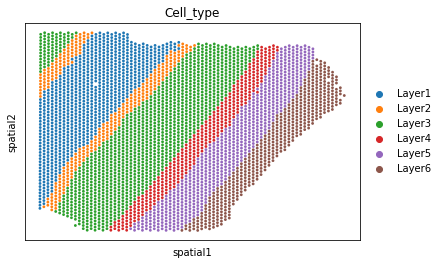

In [5]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(st_obj, basis="spatial", color="Cell_type")

In [6]:
sc_obj_hvg, st_obj_hvg = scSpace.preporcess(sc_adata=sc_obj, st_adata=st_obj, 
                                            st_type='spot', n_features=2000, normalize=True, select_hvg = 'union')

Data have been pre-processed.


In [7]:
sc_obj_hvg

View of AnnData object with n_obs × n_vars = 15928 × 2911
    obs: 'sample_id', 'sample_type', 'organism', 'donor', 'sex', 'age_days', 'brain_hemisphere', 'brain_region', 'brain_subregion', 'facs_date', 'facs_container', 'facs_sort_criteria', 'rna_amplification_set', 'library_prep_set', 'library_prep_avg_size_bp', 'seq_name', 'seq_tube', 'seq_batch', 'total_reads', 'percent_exon_reads', 'percent_intron_reads', 'percent_intergenic_reads', 'percent_rrna_reads', 'percent_mt_exon_reads', 'percent_reads_unique', 'percent_synth_reads', 'percent_ecoli_reads', 'percent_aligned_reads_total', 'complexity_cg', 'genes_detected_cpm_criterion', 'genes_detected_fpkm_criterion', 'class', 'cluster'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [17]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    
setup_seed(123)


import time
#记录开始时间
starttime = time.time()

sc_obj_hvg, st_obj_hvg = scSpace.construct_pseudo_space(
    sc_adata=sc_obj_hvg,
    st_adata=st_obj_hvg,
    dim=50,
    batch_size=128,
    hidden_size=128,
    activation='sigmoid',
    lr=0.01,
    epoch_num=1000,
    log_epoch=1000)

endtime = time.time()
print(endtime - starttime)

Beginning Transfer Component Analysis...
Transfer Component Analysis done.
Beginning training encoder for source domain...


100%|█████████████████████████████████████████████████| 1000/1000 [01:18<00:00, 12.79it/s]

Epoch [1000/1000]: Batch loss=3370.039306640625
Encoder for source domain training finished.
423.6600732803345


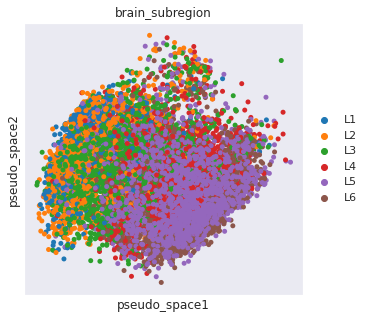

In [18]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(sc_obj_hvg, basis="pseudo_space", color="brain_subregion", s=100)

In [19]:
pd.DataFrame(sc_obj_hvg.obsm['pseudo_space']).to_csv('/home/qjy/workspace/scSpace/data/hodge/result/pseudo_space.csv')

In [20]:
pseudo_dist_group = scSpace.cal_dist_group(sc_adata=sc_obj_hvg, group_key='brain_subregion', select_group='L1')

Calculating all cell pairs between L1 and L1 ...


100%|████████████████████████████████████████████████| 1076/1076 [00:04<00:00, 261.02it/s]


Calculating all cell pairs between L1 and L2 ...


100%|████████████████████████████████████████████████| 2138/2138 [00:16<00:00, 132.12it/s]


Calculating all cell pairs between L1 and L3 ...


100%|████████████████████████████████████████████████| 3483/3483 [00:26<00:00, 132.72it/s]


Calculating all cell pairs between L1 and L4 ...


100%|████████████████████████████████████████████████| 2876/2876 [00:21<00:00, 131.19it/s]


Calculating all cell pairs between L1 and L5 ...


100%|████████████████████████████████████████████████| 3658/3658 [00:27<00:00, 132.89it/s]


Calculating all cell pairs between L1 and L6 ...


100%|████████████████████████████████████████████████| 2697/2697 [00:20<00:00, 132.11it/s]


<AxesSubplot:>

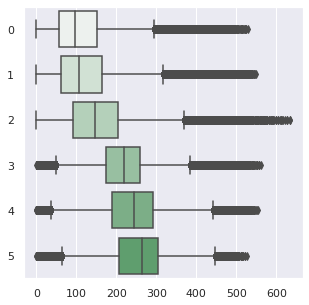

In [21]:
plt.rcParams["figure.figsize"] = (5, 5)
sns.set_theme()
# Show each distribution with both violins and points
# sns.violinplot(data=pseudo_dist_group, palette="light:g", inner="box", orient="h")
sns.boxplot(data=pseudo_dist_group, palette="light:g", orient="h")

In [22]:
save_pickle(sc_obj_hvg, '/home/qjy/workspace/scSpace/data/hodge/all_sc_obj_hvg.pkl')
save_pickle(pseudo_dist_group, '/home/qjy/workspace/scSpace/data/hodge/all_pseudo_dist_group.pkl')

In [64]:
rorb = sc_obj_hvg[sc_obj_hvg.obs['cluster'].isin(['Exc L3-4 RORB CARM1P1', 'Exc L3-5 RORB COL22A1',
                                                  'Exc L3-5 RORB ESR1', 'Exc L3-5 RORB FILIP1L', 
                                                  'Exc L3-5 RORB TWIST2', 'Exc L4-5 RORB DAPK2',
                                                  'Exc L4-5 RORB FOLH1B', 'Exc L4-6 RORB C1R', 
                                                  'Exc L4-6 RORB SEMA3E', 'Exc L5-6 RORB TTC12'])]
rorb = scSpace.spatial_cluster(
    sc_adata=rorb,
    Ks=5,
    Kg=20,
    res=1,
    target_num=10
)
rorb.obs.to_csv('~/workspace/scSpace/data/hodge/result/rorb_cluster.csv')

Start at res =  1 step =  0.1
Res =  1 number of clusters =  12
Res =  0.9 number of clusters =  10
Recommended res =  0.9


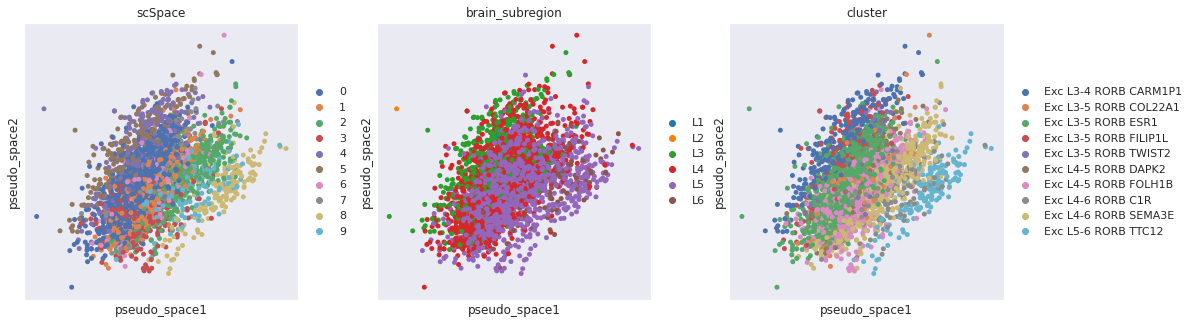

In [65]:
# Ks=5, Kg=20, ARI=0.0.8134998
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(rorb, basis="pseudo_space", color=["scSpace", "brain_subregion", "cluster"], s=100)

In [4]:
sc_obj_hvg = load_pickle('/home/qjy/workspace/scSpace/data/hodge/all_sc_obj_hvg.pkl')
pseudo_dist_group = load_pickle('/home/qjy/workspace/scSpace/data/hodge/all_pseudo_dist_group.pkl')

In [20]:
fezf2 = sc_obj_hvg[sc_obj_hvg.obs['cluster'].isin(['Exc L4-5 FEZF2 SCN4B', 'Exc L4-6 FEZF2 IL26',
                                                   'Exc L5-6 FEZF2 ABO', 'Exc L5-6 FEZF2 EFTUD1P1', 
                                                   'Exc L5-6 SLC17A7 IL15', 'Exc L6 FEZF2 OR2T8',
                                                   'Exc L6 FEZF2 SCUBE1'])]
fezf2 = scSpace.spatial_cluster(
    sc_adata=fezf2,
    Ks=5,
    Kg=5,
    res=1,
    target_num=7
)
fezf2.obs.to_csv('~/workspace/scSpace/data/hodge/result/fezf2_cluster.csv')

Start at res =  1 step =  0.1
Res =  1 number of clusters =  17
Res =  0.9 number of clusters =  16
Res changed to 0.9
Res =  0.8 number of clusters =  16
Res changed to 0.8
Res =  0.7000000000000001 number of clusters =  16
Res changed to 0.7000000000000001
Res =  0.6000000000000001 number of clusters =  15
Res changed to 0.6000000000000001
Res =  0.5000000000000001 number of clusters =  12
Res changed to 0.5000000000000001
Res =  0.40000000000000013 number of clusters =  11
Res changed to 0.40000000000000013
Res =  0.30000000000000016 number of clusters =  8
Res changed to 0.30000000000000016
Res =  0.20000000000000015 number of clusters =  5
Step changed to 0.05
Res =  0.25000000000000017 number of clusters =  7
Recommended res =  0.25000000000000017


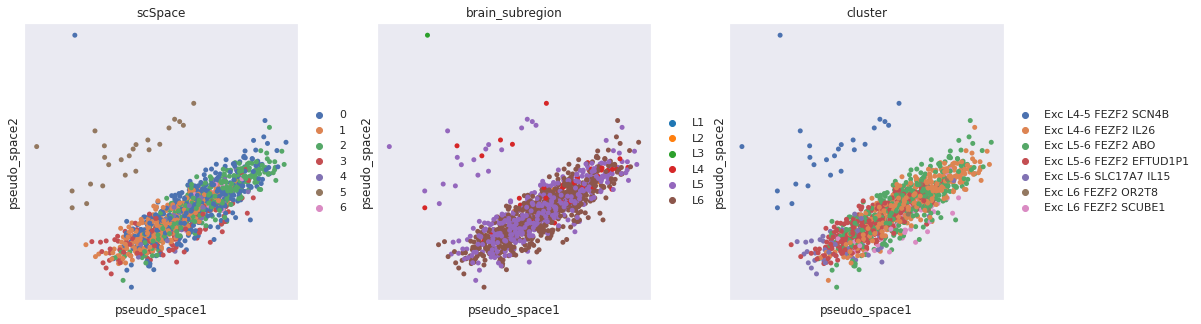

In [21]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(fezf2, basis="pseudo_space", color=["scSpace", "brain_subregion", "cluster"], s=100)

In [40]:
themis = sc_obj_hvg[sc_obj_hvg.obs['cluster'].isin(['Exc L5-6 THEMIS C1QL3', 'Exc L5-6 THEMIS CRABP1',
                                                   'Exc L5-6 THEMIS DCSTAMP', 'Exc L5-6 THEMIS FGF10'])]
themis = scSpace.spatial_cluster(
    sc_adata=themis,
    Ks=20,
    Kg=5,
    res=1,
    target_num=4
)
themis.obs.to_csv('~/workspace/scSpace/data/hodge/result/themis_cluster.csv')

Start at res =  1 step =  0.1
Res =  1 number of clusters =  16
Res =  0.9 number of clusters =  13
Res changed to 0.9
Res =  0.8 number of clusters =  13
Res changed to 0.8
Res =  0.7000000000000001 number of clusters =  10
Res changed to 0.7000000000000001
Res =  0.6000000000000001 number of clusters =  11
Res changed to 0.6000000000000001
Res =  0.5000000000000001 number of clusters =  10
Res changed to 0.5000000000000001
Res =  0.40000000000000013 number of clusters =  8
Res changed to 0.40000000000000013
Res =  0.30000000000000016 number of clusters =  6
Res changed to 0.30000000000000016
Res =  0.20000000000000015 number of clusters =  3
Step changed to 0.05
Res =  0.25000000000000017 number of clusters =  5
Res changed to 0.25000000000000017
Res =  0.20000000000000018 number of clusters =  3
Step changed to 0.025
Res =  0.22500000000000017 number of clusters =  4
Recommended res =  0.22500000000000017


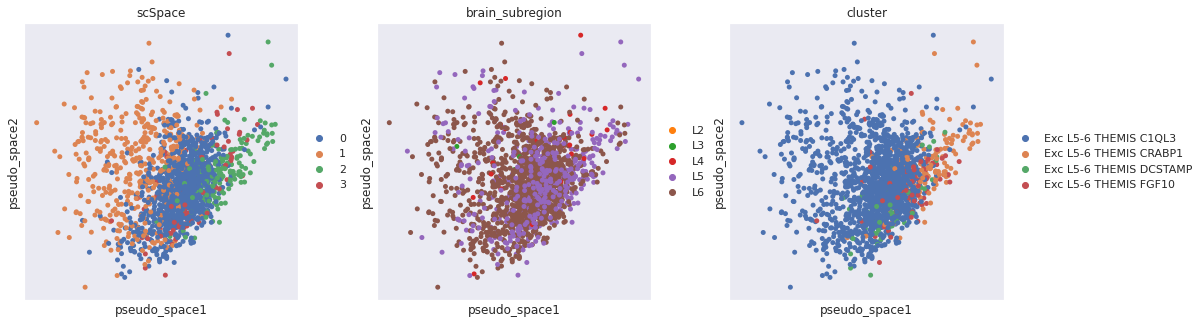

In [35]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(themis, basis="pseudo_space", color=["scSpace", "brain_subregion", "cluster"], s=100)

In [50]:
lamp5 = sc_obj_hvg[sc_obj_hvg.obs['cluster'].isin(['Exc L2 LAMP5 LTK', 'Exc L2-3 LINC00507 FREM3',
                                                   'Exc L2-4 LINC00507 GLP2R'])]
lamp5 = scSpace.spatial_cluster(
    sc_adata=lamp5,
    Ks=5,
    Kg=20,
    res=1,
    target_num=3
)
lamp5.obs.to_csv('~/workspace/scSpace/data/hodge/result/lamp5_cluster.csv')

Start at res =  1 step =  0.1
Res =  1 number of clusters =  11
Res =  0.9 number of clusters =  11
Res changed to 0.9
Res =  0.8 number of clusters =  9
Res changed to 0.8
Res =  0.7000000000000001 number of clusters =  9
Res changed to 0.7000000000000001
Res =  0.6000000000000001 number of clusters =  7
Res changed to 0.6000000000000001
Res =  0.5000000000000001 number of clusters =  7
Res changed to 0.5000000000000001
Res =  0.40000000000000013 number of clusters =  5
Res changed to 0.40000000000000013
Res =  0.30000000000000016 number of clusters =  4
Res changed to 0.30000000000000016
Res =  0.20000000000000015 number of clusters =  3
Recommended res =  0.20000000000000015


In [ ]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.embedding(lamp5, basis="pseudo_space", color=["scSpace", "brain_subregion", "cluster"], s=100)

In [13]:
vip = sc_obj_hvg[sc_obj_hvg.obs['cluster'].isin(['Inh L1 SST CHRNA4', 'Inh L1-2 GAD1 MC4R', 'Inh L1-2 SST BAGE2',
                                                 'Inh L1-2 VIP TSPAN12', 'Inh L1-2 VIP LBH', 'Inh L1-2 VIP PCDH20',
                                                 'Inh L1-3 VIP CHRM2', 'Inh L1-3 VIP GGH', 'Inh L1-3 VIP CCDC184',
                                                 'Inh L1-3 PAX6 SYT6', 'Inh L1-4 VIP CHRNA6', 'Inh L1-3 VIP ADAMTSL1',
                                                 'Inh L1-4 VIP PENK', 'Inh L1-4 VIP OPRM1', 'Inh L2-3 VIP CASC6',
                                                 'Inh L2-4 VIP SPAG17', 'Inh L2-4 VIP CBLN1', 'Inh L2-5 VIP SERPINF1',
                                                 'Inh L2-5 VIP TYR', 'Inh L2-6 VIP QPCT', 'Inh L3-6 VIP HS3ST3A1'])]
vip = scSpace.spatial_cluster(
    sc_adata=vip,
    Ks=5,
    Kg=5,
    res=2,
    target_num=21
)
vip.obs.to_csv('~/workspace/scSpace/data/hodge/result/vip_cluster.csv')

Start at res =  2 step =  0.1
Res =  2 number of clusters =  31
Res =  1.9 number of clusters =  28
Res changed to 1.9
Res =  1.7999999999999998 number of clusters =  28
Res changed to 1.7999999999999998
Res =  1.6999999999999997 number of clusters =  27
Res changed to 1.6999999999999997
Res =  1.5999999999999996 number of clusters =  26
Res changed to 1.5999999999999996
Res =  1.4999999999999996 number of clusters =  25
Res changed to 1.4999999999999996
Res =  1.3999999999999995 number of clusters =  25
Res changed to 1.3999999999999995
Res =  1.2999999999999994 number of clusters =  24
Res changed to 1.2999999999999994
Res =  1.1999999999999993 number of clusters =  25
Res changed to 1.1999999999999993
Res =  1.0999999999999992 number of clusters =  23
Res changed to 1.0999999999999992
Res =  0.9999999999999992 number of clusters =  23
Res changed to 0.9999999999999992
Res =  0.8999999999999992 number of clusters =  19
Step changed to 0.05
Res =  0.9499999999999992 number of clusters

In [18]:
pax6 = sc_obj_hvg[sc_obj_hvg.obs['cluster'].isin(['Inh L1-2 LAMP5 DBP', 'Inh L1 SST NMBR', 'Inh L1-2 PAX6 CDH12',
                                                  'Inh L1-2 PAX6 TNFAIP8L3', 'Inh L1-4 LAMP5 LCP2', 
                                                  'Inh L2-6 LAMP5 CA1'])]
pax6 = scSpace.spatial_cluster(
    sc_adata=pax6,
    Ks=5,
    Kg=10,
    res=1,
    target_num=6
)
pax6.obs.to_csv('~/workspace/scSpace/data/hodge/result/pax6_cluster.csv')

Start at res =  1 step =  0.1
Res =  1 number of clusters =  11
Res =  0.9 number of clusters =  10
Res changed to 0.9
Res =  0.8 number of clusters =  8
Res changed to 0.8
Res =  0.7000000000000001 number of clusters =  8
Res changed to 0.7000000000000001
Res =  0.6000000000000001 number of clusters =  7
Res changed to 0.6000000000000001
Res =  0.5000000000000001 number of clusters =  6
Recommended res =  0.5000000000000001


In [72]:
sst = sc_obj_hvg[sc_obj_hvg.obs['cluster'].isin(['Inh L1-3 SST CALB1', 'Inh L2-4 SST FRZB', 'Inh L3-5 SST ADGRG6',
            'Inh L4-5 SST STK32A', 'Inh L4-6 SST B3GAT2', 'Inh L3-6 SST HPGD',
            'Inh L3-6 SST NPY', 'Inh L4-6 SST GXYLT2', 'Inh L5-6 SST KLHDC8A',
            'Inh L5-6 SST TH', 'Inh L5-6 SST NPM1P10'])]
sst = scSpace.spatial_cluster(
    sc_adata=sst,
    Ks=25,
    Kg=4,
    res=1,
    target_num=11
)
sst.obs.to_csv('~/workspace/scSpace/data/hodge/result/sst_cluster.csv')

Start at res =  1 step =  0.1
Res =  1 number of clusters =  19
Res =  0.9 number of clusters =  18
Res changed to 0.9
Res =  0.8 number of clusters =  17
Res changed to 0.8
Res =  0.7000000000000001 number of clusters =  16
Res changed to 0.7000000000000001
Res =  0.6000000000000001 number of clusters =  17
Res changed to 0.6000000000000001
Res =  0.5000000000000001 number of clusters =  15
Res changed to 0.5000000000000001
Res =  0.40000000000000013 number of clusters =  14
Res changed to 0.40000000000000013
Res =  0.30000000000000016 number of clusters =  12
Res changed to 0.30000000000000016
Res =  0.20000000000000015 number of clusters =  9
Step changed to 0.05
Res =  0.25000000000000017 number of clusters =  11
Recommended res =  0.25000000000000017


In [109]:
pvalb = sc_obj_hvg[sc_obj_hvg.obs['cluster'].isin(['Inh L2-4 PVALB WFDC2', 'Inh L2-5 PVALB SCUBE3', 'Inh L4-6 PVALB SULF1',
            'Inh L4-5 PVALB MEPE', 'Inh L5-6 SST MIR548F2', 'Inh L5-6 PVALB LGR5',
            'Inh L5-6 GAD1 GLP1R'])]
pvalb = scSpace.spatial_cluster(
    sc_adata=pvalb,
    Ks=15,
    Kg=20,
    res=1,
    target_num=7
)
pvalb.obs.to_csv('~/workspace/scSpace/data/hodge/result/pvalb_cluster.csv')

Start at res =  1 step =  0.1
Res =  1 number of clusters =  10
Res =  0.9 number of clusters =  9
Res changed to 0.9
Res =  0.8 number of clusters =  9
Res changed to 0.8
Res =  0.7000000000000001 number of clusters =  7
Recommended res =  0.7000000000000001
